In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (4, 4), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (64598, 56, 56)   out (64598, 12, 12)
in (8075, 56, 56)   out (8075, 12, 12)


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(64598, 56, 56, 1) (64598, 12, 12, 1)
(8075, 56, 56, 1) (8075, 12, 12, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

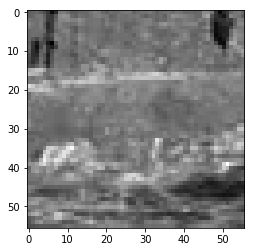

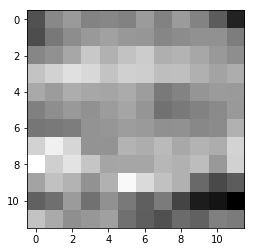

In [8]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [16]:
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

In [10]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])], trainable=False)(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1180

In [64]:
# from keras.callbacks import Callback

# # taken from https://github.com/keras-team/keras/issues/7874#issuecomment-329347949

# class LRPrintCallback(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr = self.model.optimizer.lr
#         decay = self.model.optimizer.decay
#         iterations = self.model.optimizer.iterations
#         lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
#         print(K.eval(lr_with_decay))
#         print(K.eval(lr))
#         print(K.eval(decay))
        
# lr_printer = LRPrintCallback()

In [11]:
model_version_previous = '0.0.0.3.4_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.001_200moreepochs'
brief_ae_previous = load_model('/scratch/image_datasets/2_for_learned_brief/ridiculously_small' + '/brief_ae_' + model_version_previous + '.h5')

In [12]:
brief_ae_previous.get_layer(index=7).get_weights()[0].shape

(512, 1152)

In [13]:
for i in range(7, len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [61]:
# brief_ae = load_model('/scratch/image_datasets/2_for_learned_brief/ridiculously_small/brief_ae_0.0.0.3.4_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.001_200moreepochs.h5')
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.01, rho=0.95)
# # my_adadelta = keras.optimizers.Adadelta(learning_rate=0.1, decay=0.95)
# brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")

In [14]:
model_version = '0.0.2.0.0_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
64598/64598 [==============================] - 1536s 24ms/step - loss: 0.6338 - val_loss: 0.6708
Epoch 2/50
64598/64598 [==============================] - 1537s 24ms/step - loss: 0.6282 - val_loss: 0.6341
Epoch 3/50
64598/64598 [==============================] - 1536s 24ms/step - loss: 0.6259 - val_loss: 0.6251
Epoch 4/50
64598/64598 [==============================] - 1536s 24ms/step - loss: 0.6243 - val_loss: 0.6275
Epoch 5/50
64598/64598 [==============================] - 1535s 24ms/step - loss: 0.6230 - val_loss: 0.6647
Epoch 6/50
64598/64598 [==============================] - 1536s 24ms/step - loss: 0.6221 - val_loss: 0.6066
Epoch 7/50
64598/64598 [==============================] - 1535s 24ms/step - loss: 0.6212 - val_loss: 0.6451
Epoch 8/50
64598/64598 [==============================] - 1536s 24ms/step - loss: 0.6205 - val_loss: 0.6413
Epoch 9/50
64598/64598 [==============================] - 1535s 24ms/step - loss: 0.6198 - val_loss: 0.6187
Epoch 10/50
64598/64598 [===

predictions: 


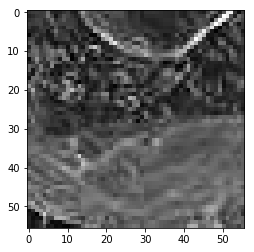

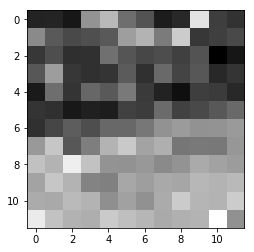

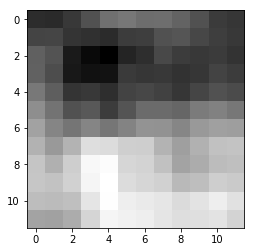

32.229501977562904

 next


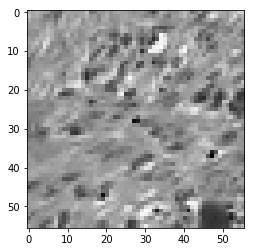

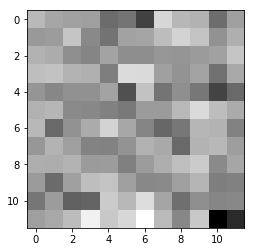

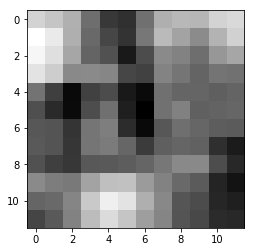

50.613116919994354

 next


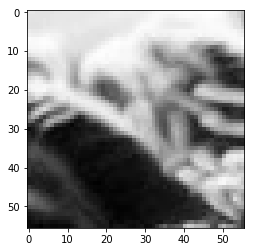

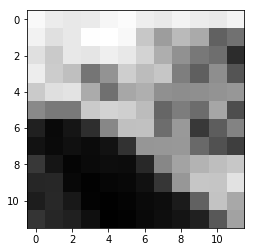

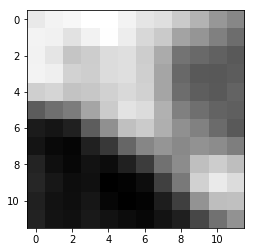

30.582518354058266

 next


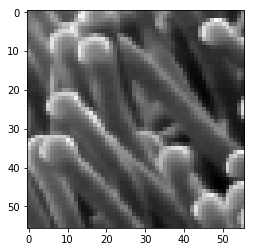

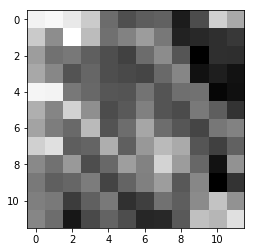

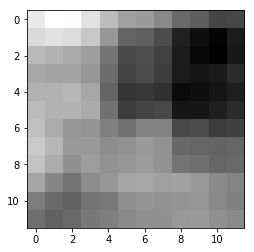

22.526830919086933

 next


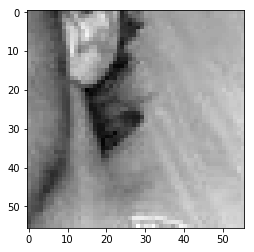

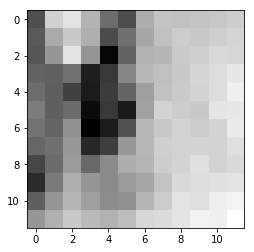

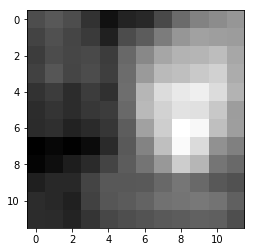

29.07559521496296

 next


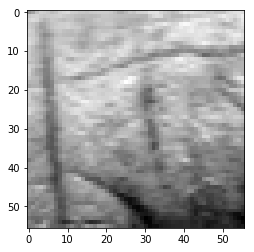

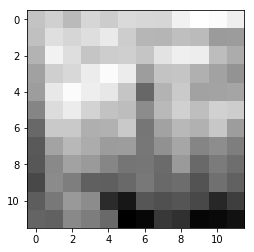

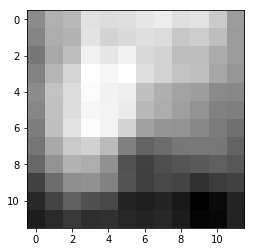

47.136675864458084

 next


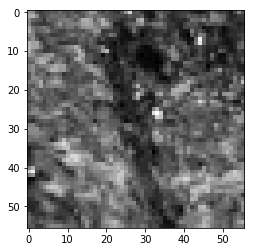

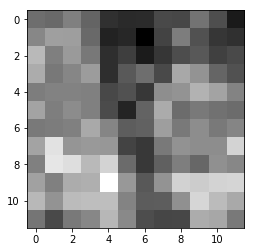

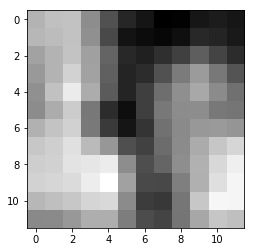

35.04534088075161

 next


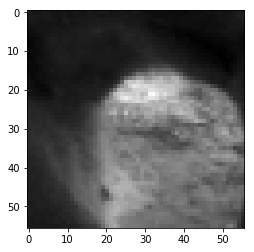

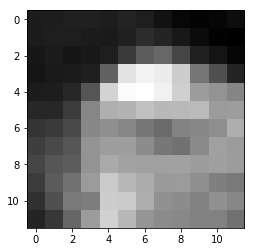

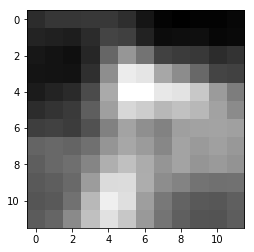

17.749229483306408

 next


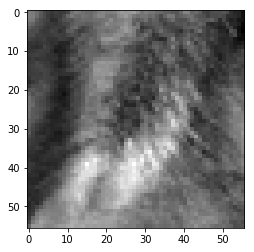

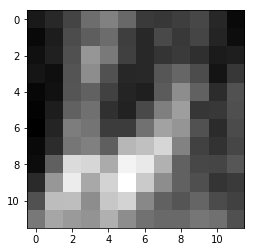

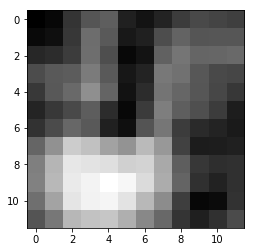

35.8638321608305

 next


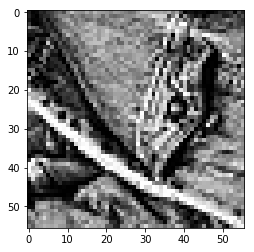

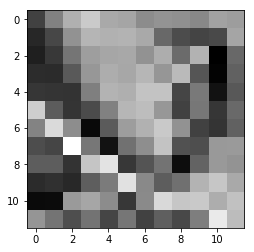

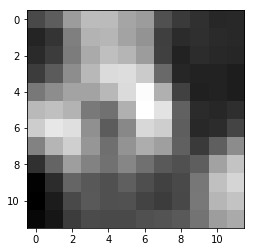

42.1766272187233

 next


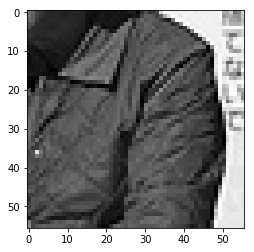

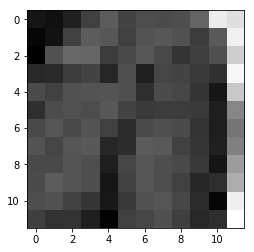

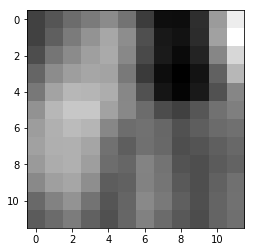

42.42476910352707

 next


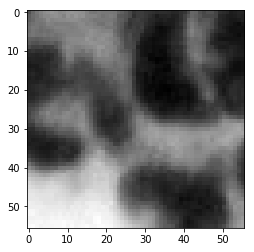

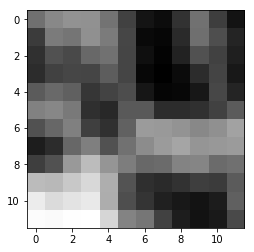

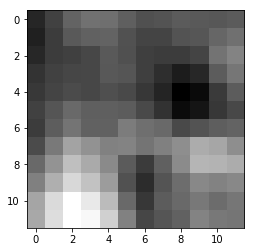

26.522812396287918

 next


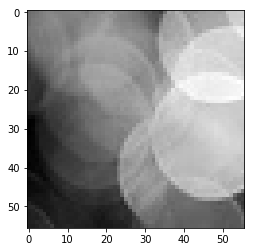

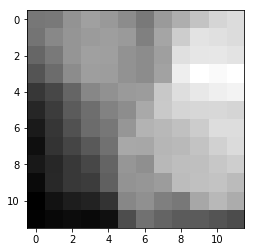

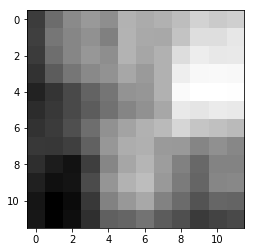

20.682369992136955

 next


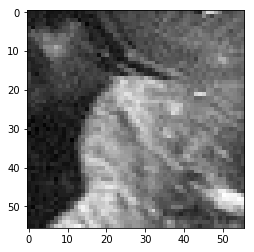

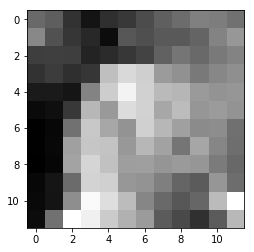

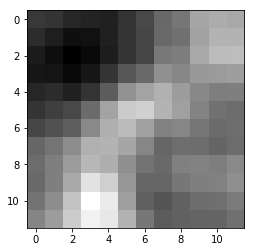

19.315133057534695

 next


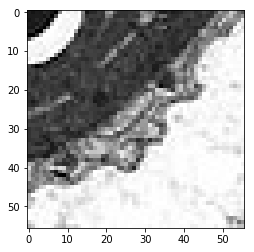

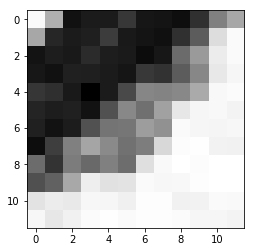

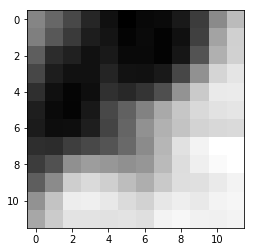

44.16062995791435

 next


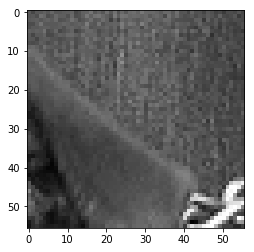

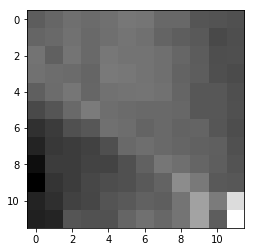

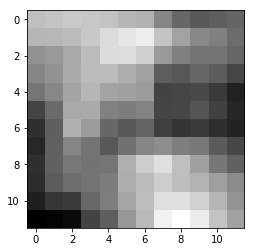

18.15792415291071

 next


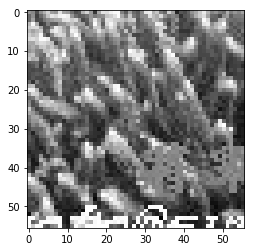

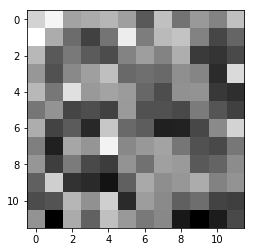

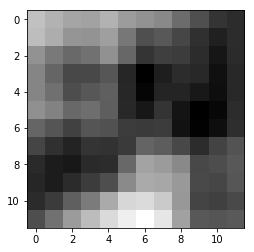

47.45367385447025

 next


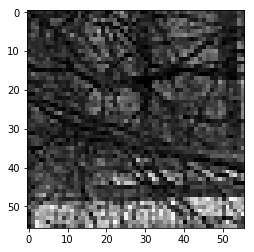

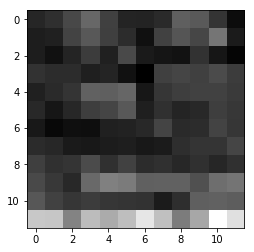

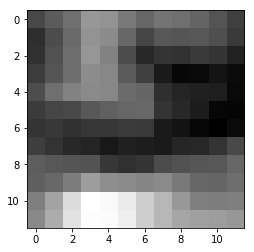

42.63709031045437

 next


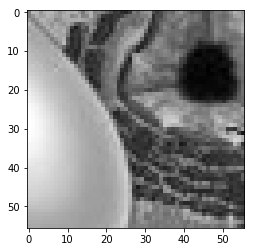

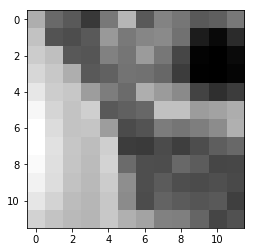

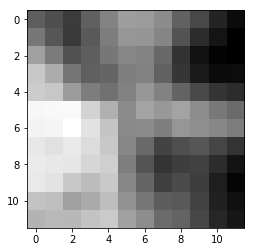

25.441960394382477

 next


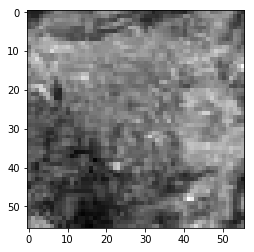

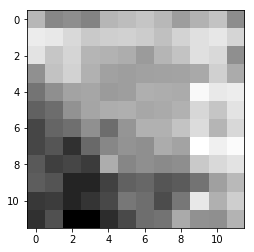

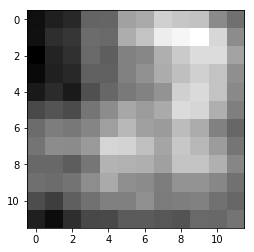

11.440900135785341

 next


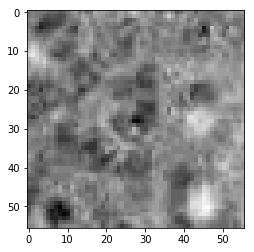

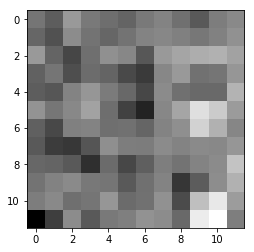

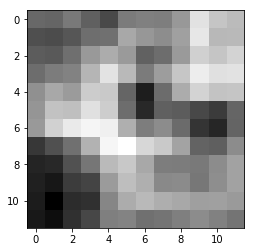

60.95436841249466

 next


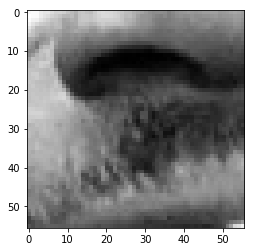

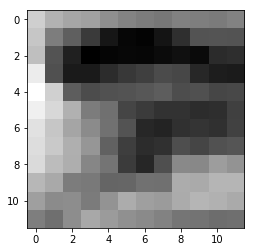

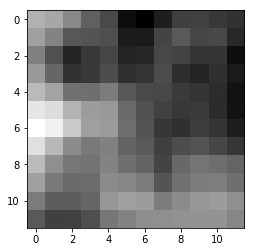

52.773832976818085

 next


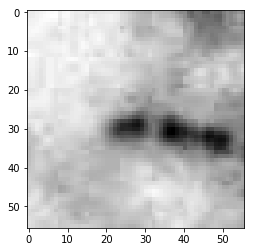

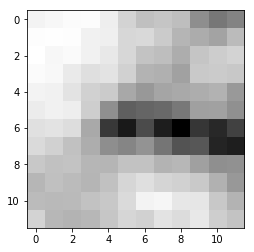

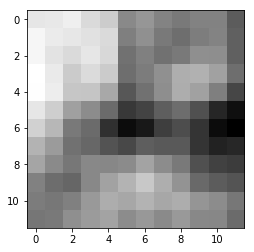

37.94420912861824

 next


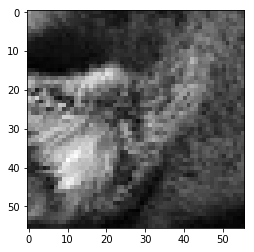

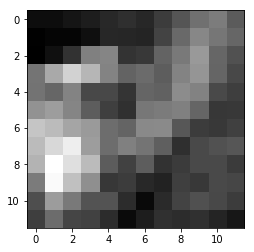

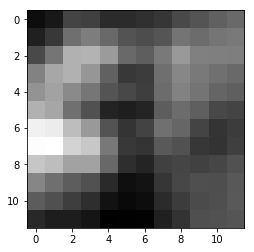

53.322705924510956

 next


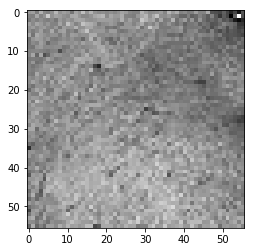

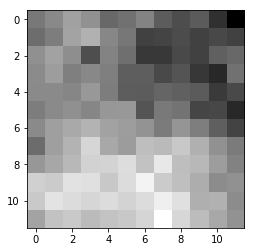

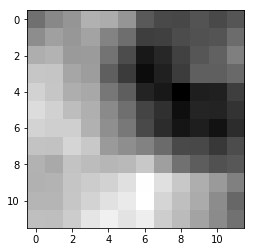

56.06061860918999

 next


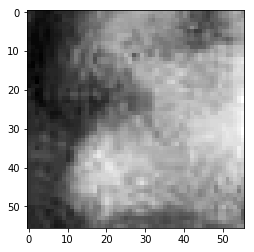

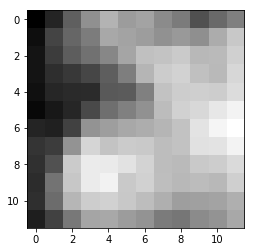

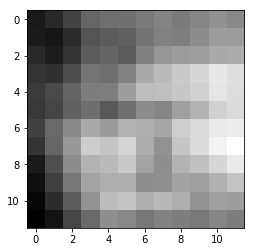

33.429865166544914

 next


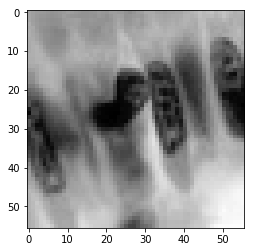

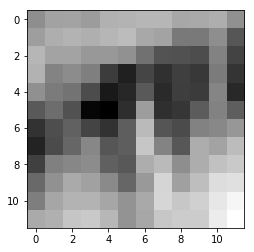

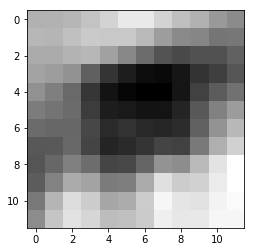

26.196102127432823

 next


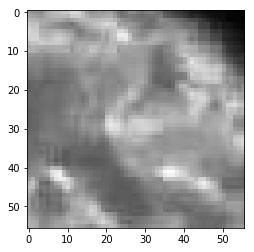

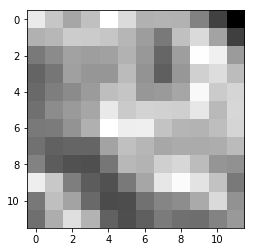

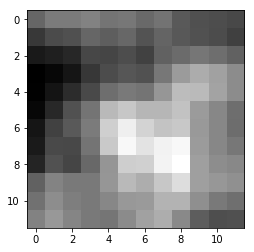

19.30802743881941

 next


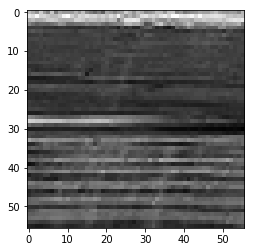

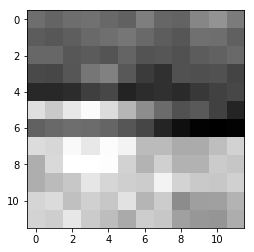

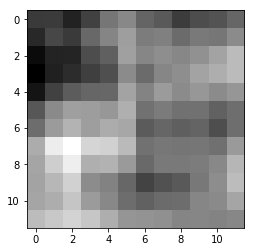

22.522058375179768

 next


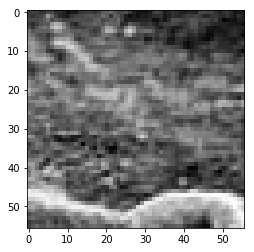

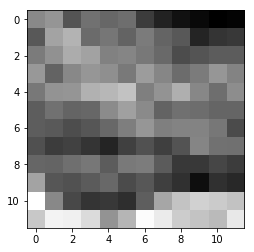

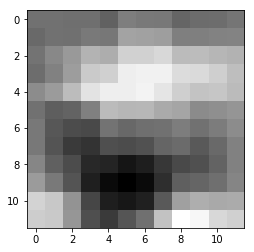

86.70791208744049

 next


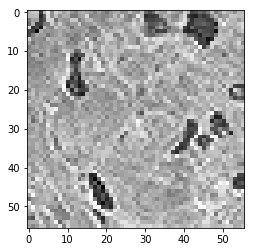

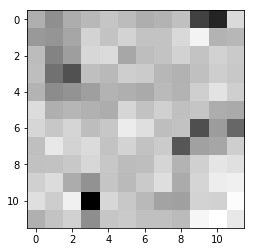

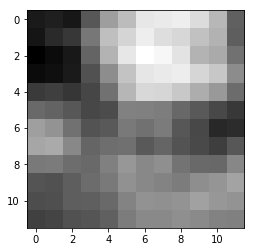

71.51090875267982

 next


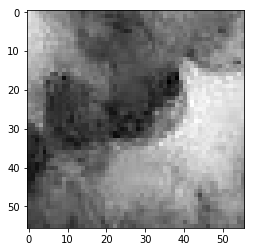

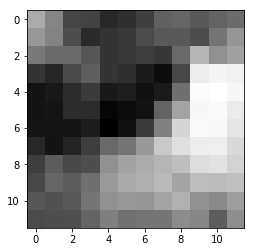

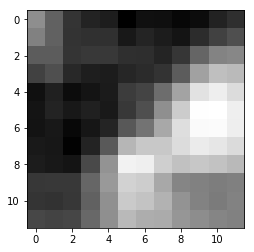

38.98420192301273

 next


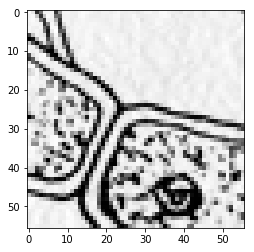

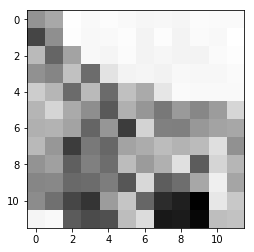

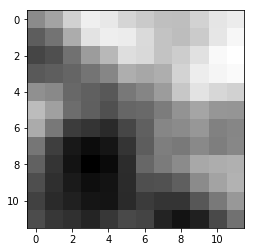

78.4684494137764

 next


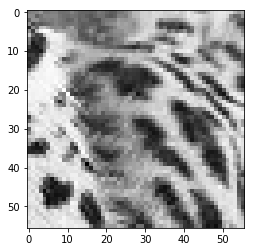

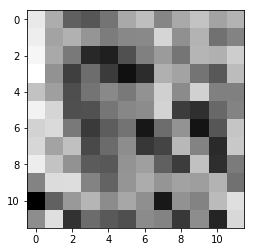

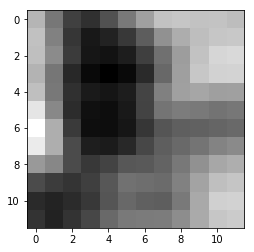

74.54603388905525

 next


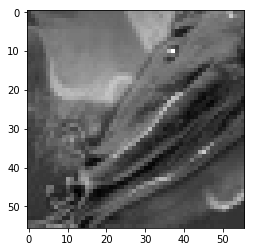

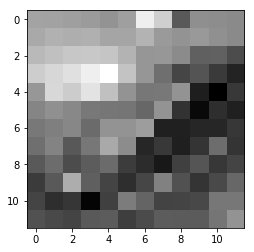

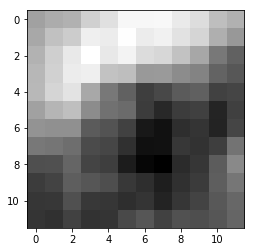

26.63607481867075

 next


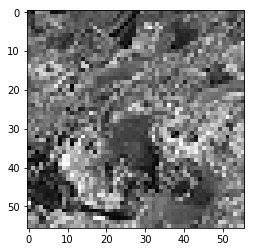

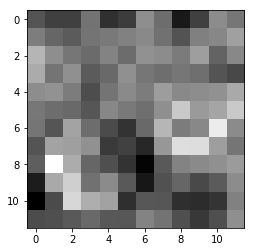

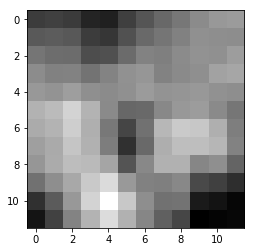

50.1066192984581

 next


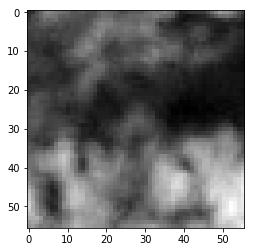

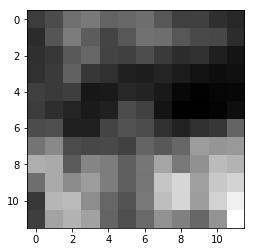

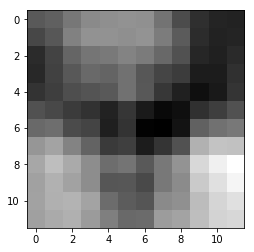

42.06447243690491

 next


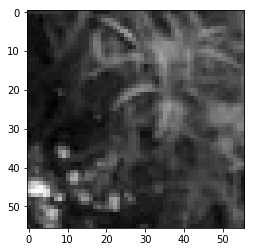

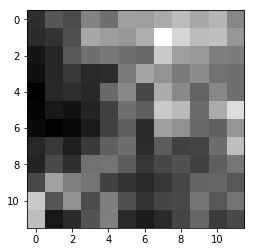

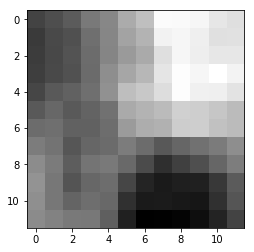

52.314099445939064

 next


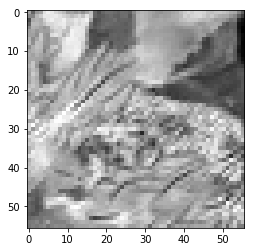

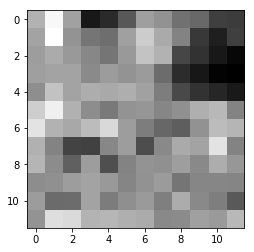

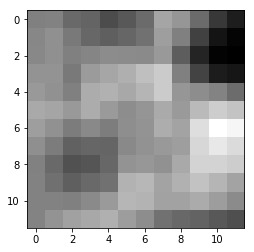

46.07726611196995

 next


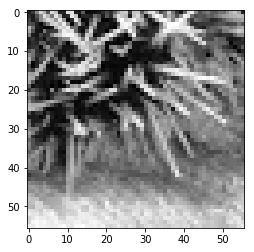

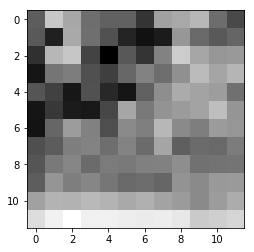

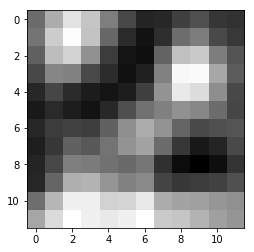

32.488480880856514

 next


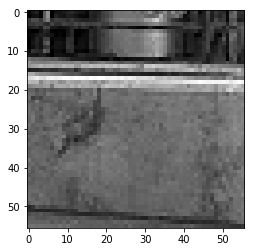

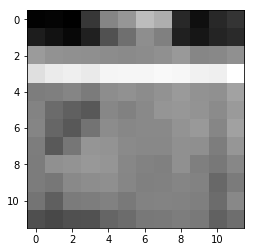

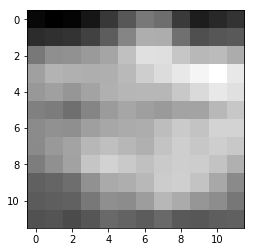

55.881344228982925

 next


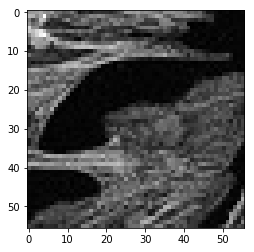

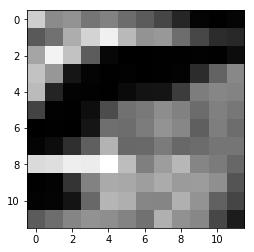

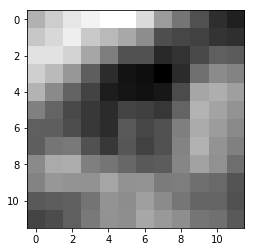

75.75867041945457

 next


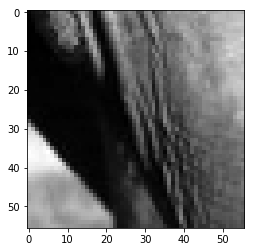

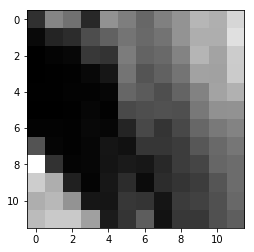

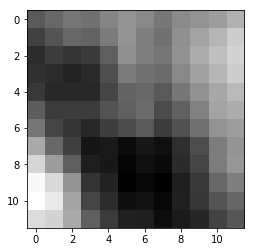

37.26269669830799

 next


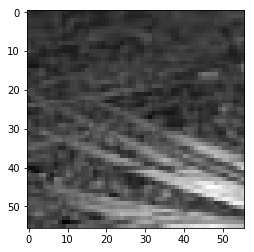

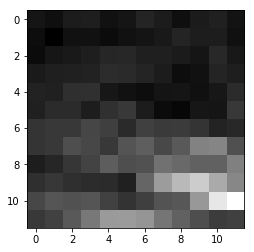

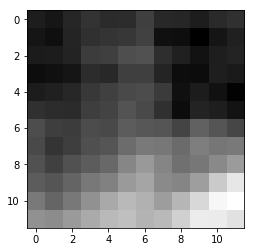

16.69987589120865

 next


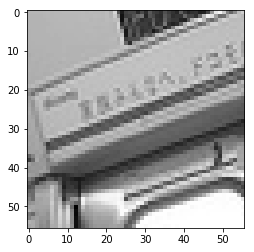

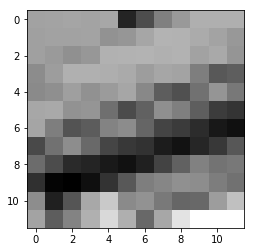

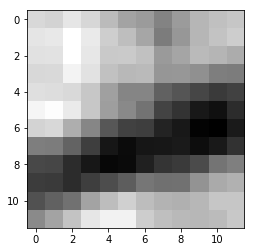

37.96584516763687

 next


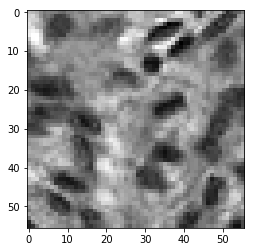

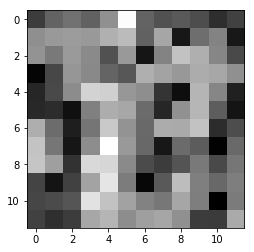

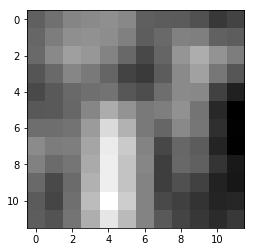

25.851407423615456

 next


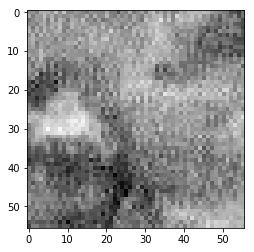

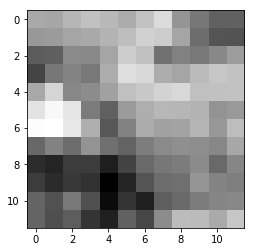

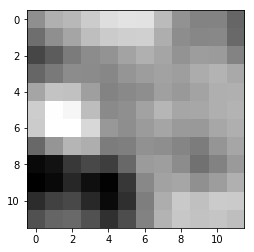

21.418341100215912

 next


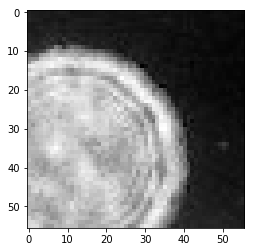

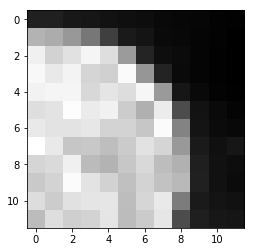

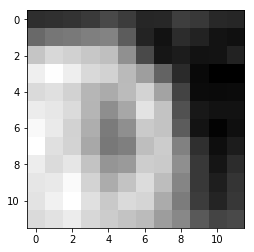

34.257095977663994

 next


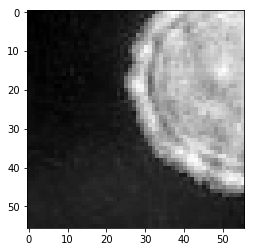

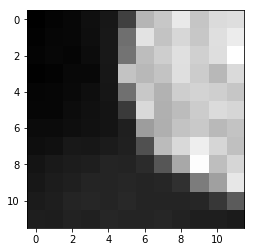

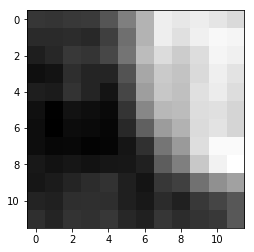

52.02683486044407

 next


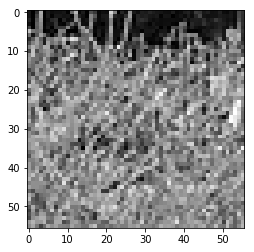

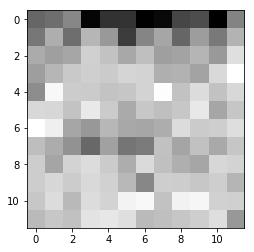

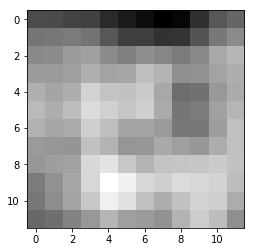

21.858498081564903

 next


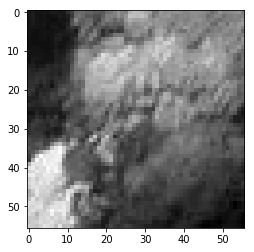

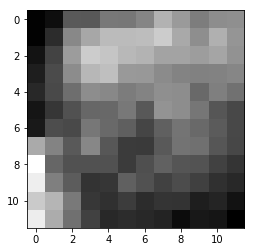

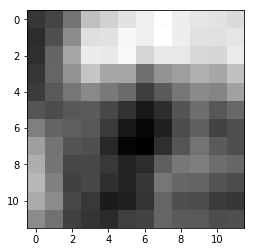

32.601657807826996

 next


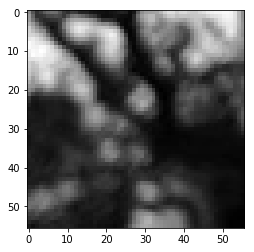

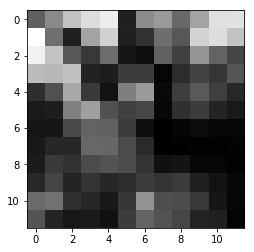

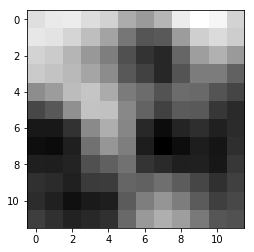

45.239528864622116

 next


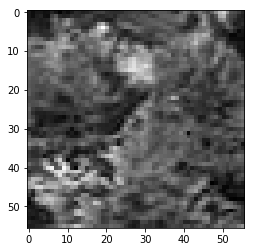

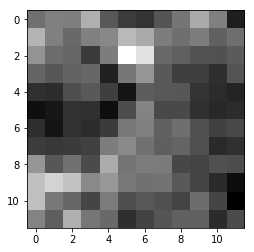

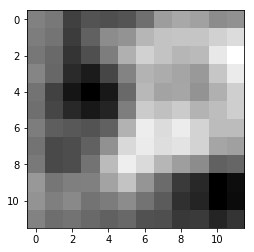

49.470286443829536

 next


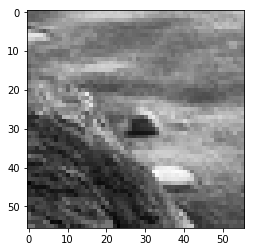

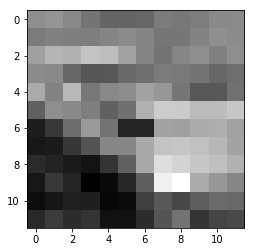

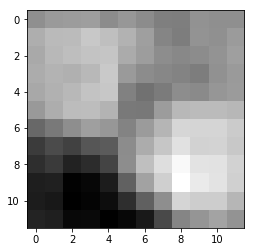

37.819203436374664

 next


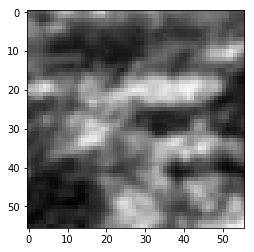

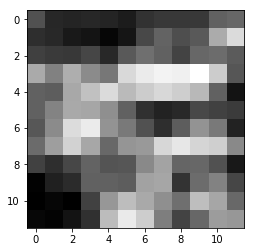

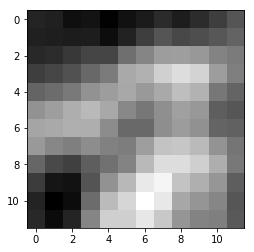

17.42208793759346

 next


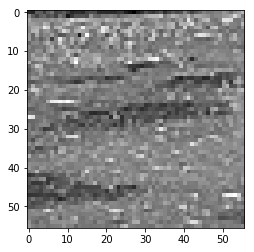

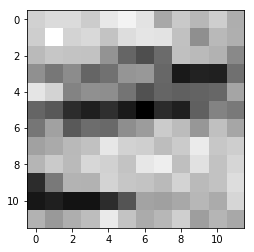

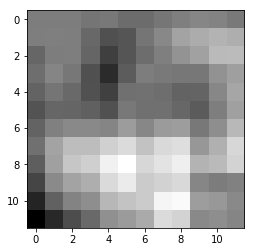

19.908355325460434

 next


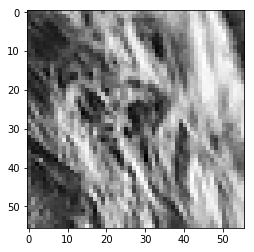

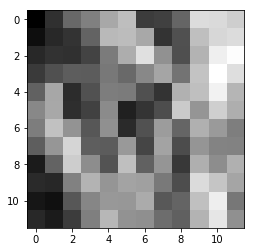

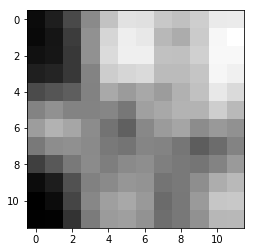

33.70910458266735

 next


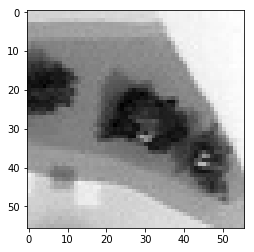

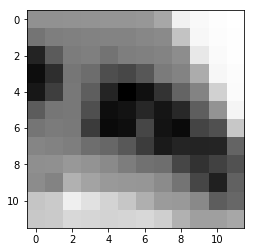

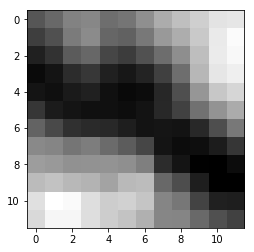

21.781056337058544

 next


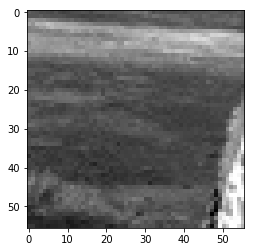

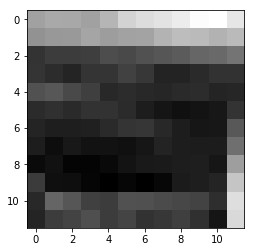

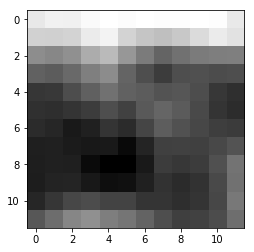

28.428767323493958

 next


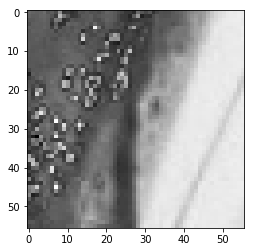

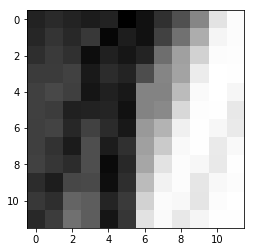

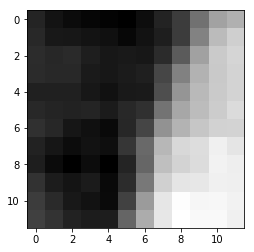

55.33071957528591

 next


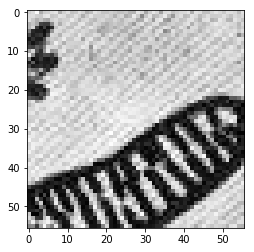

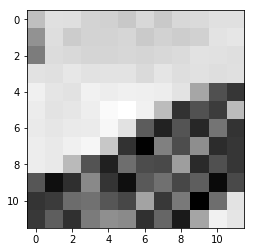

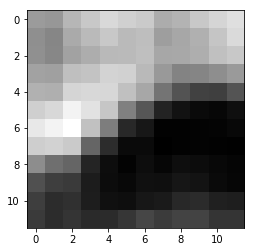

67.61196836829185

 next


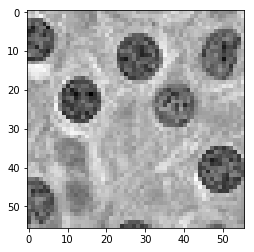

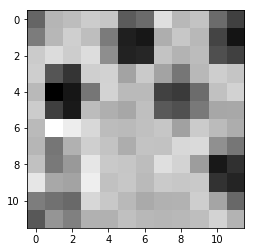

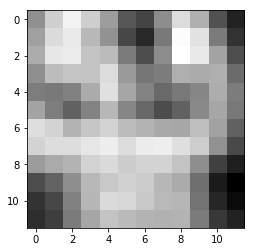

40.716532766819

 next


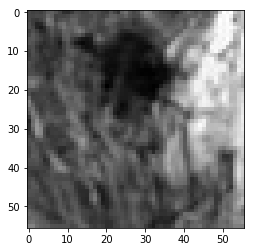

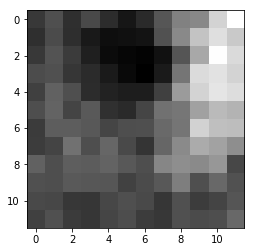

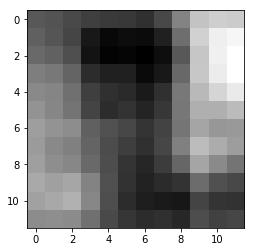

30.36161720752716

 next


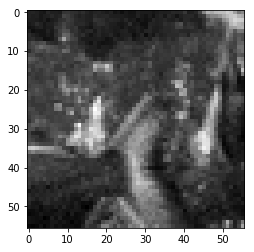

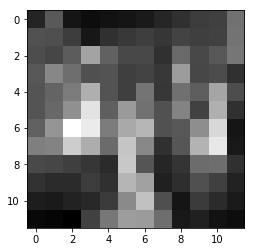

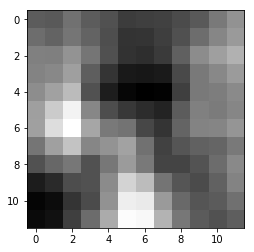

34.21630136668682

 next


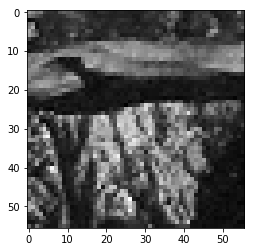

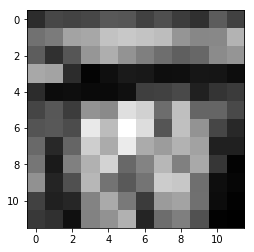

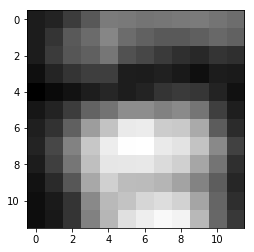

55.32573044300079

 next


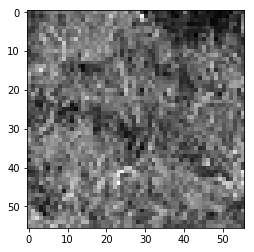

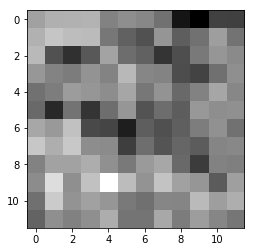

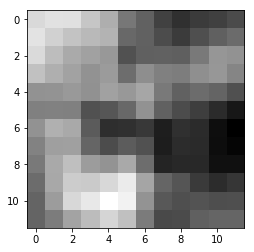

21.10544688999653

 next


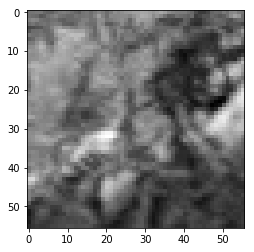

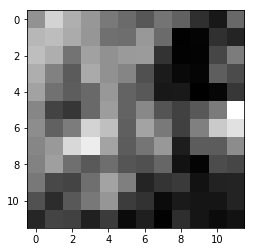

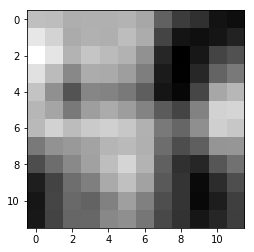

19.48301374912262

 next


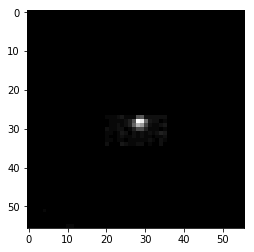

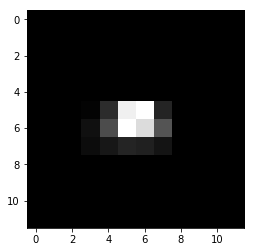

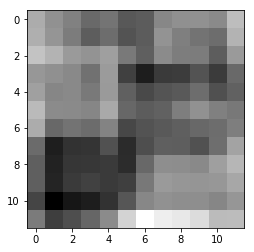

72.5840775668621

 next


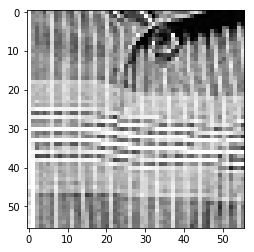

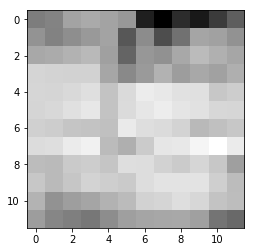

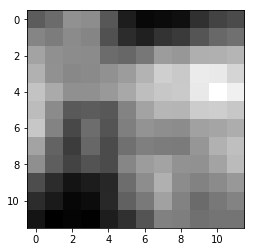

58.59132081270218

 next


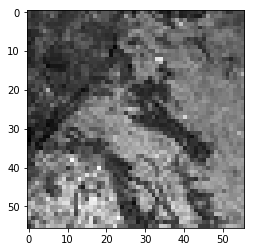

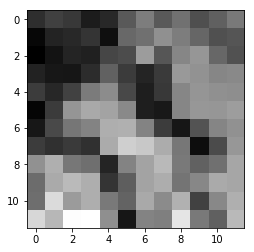

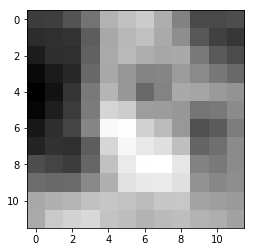

28.203861191868782

 next


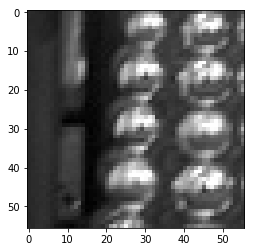

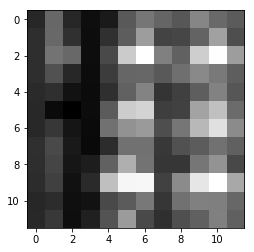

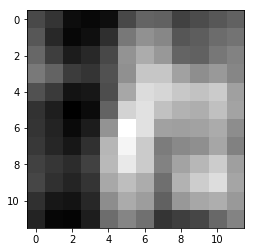

37.568029314279556

 next


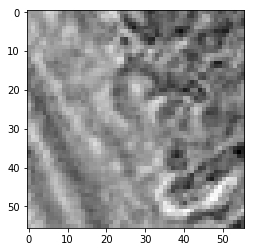

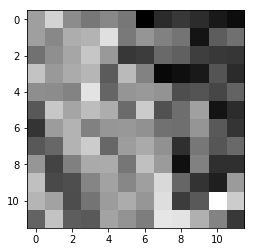

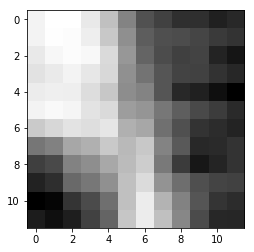

71.50426670908928

 next


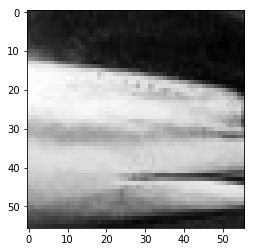

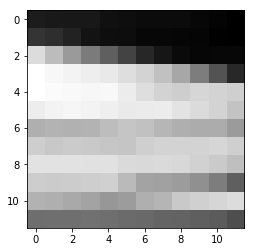

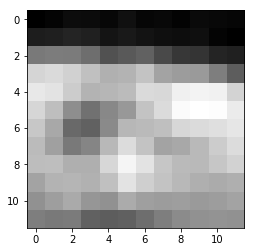

41.11573174595833

 next


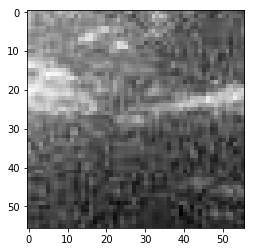

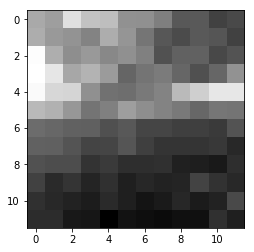

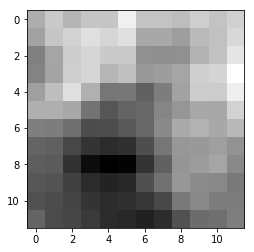

66.26314714550972

 next


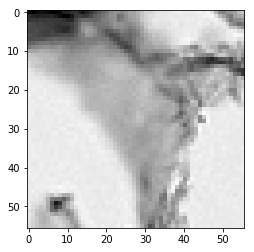

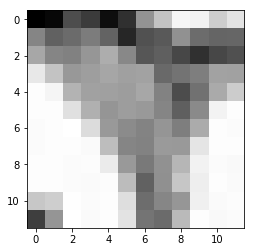

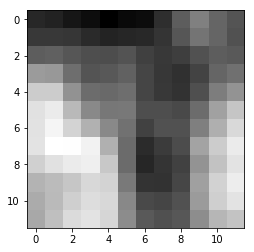

79.36806634068489

 next


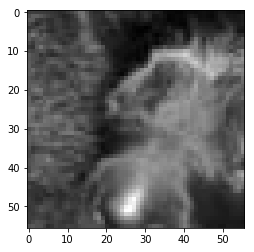

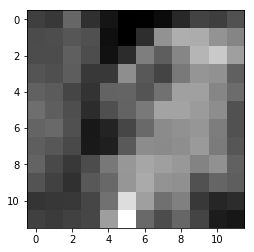

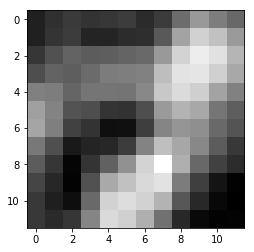

24.785178937017918

 next


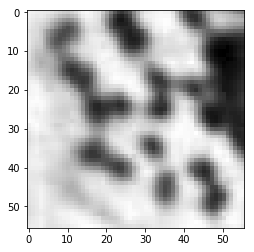

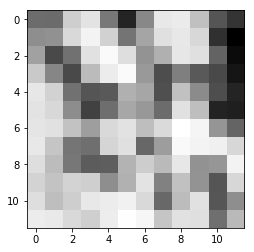

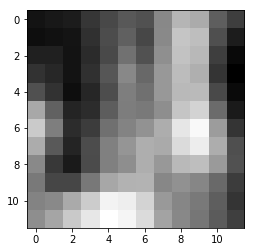

76.15283086895943

 next


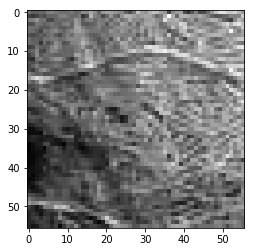

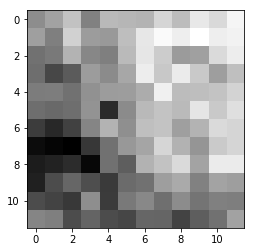

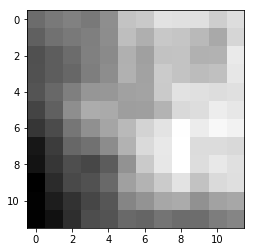

17.404907159507275

 next


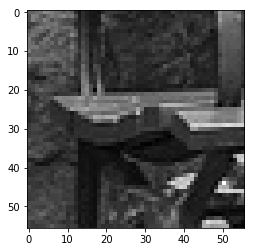

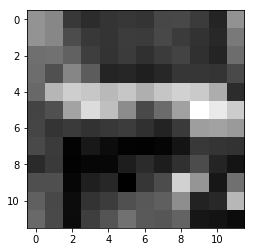

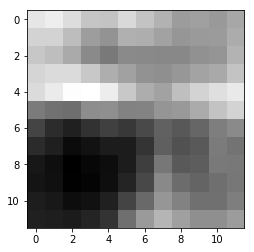

35.88633835315704

 next


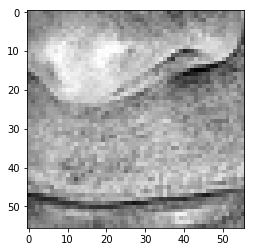

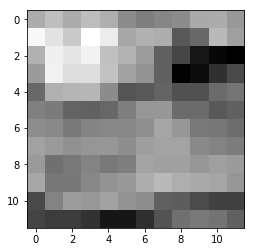

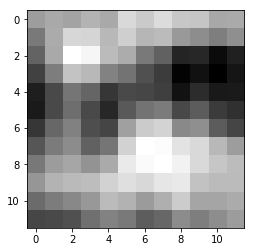

73.43894809484482

 next


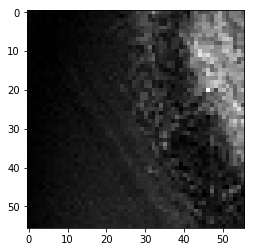

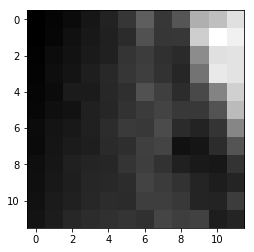

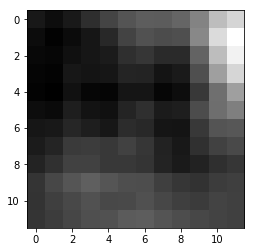

54.321919307112694

 next


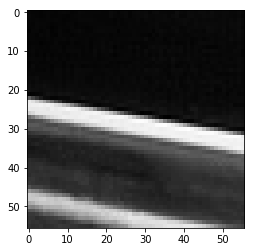

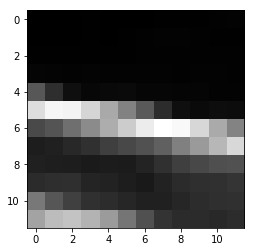

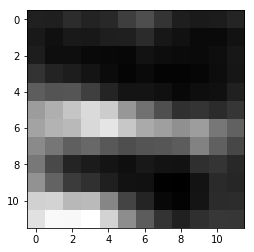

37.68513523042202

 next


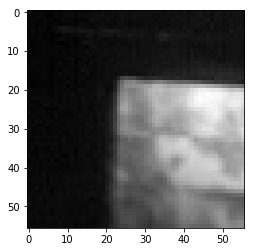

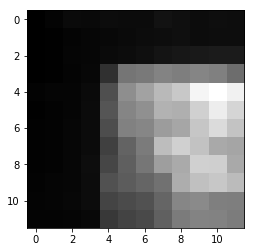

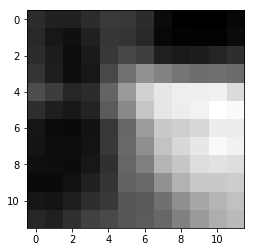

23.3570521697402

 next


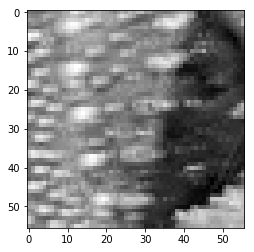

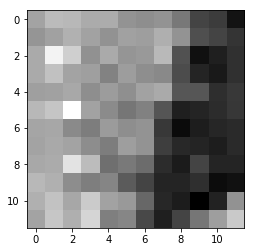

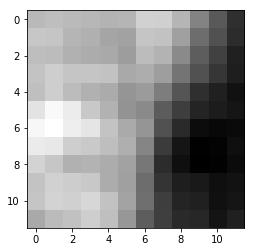

38.66827927529812

 next


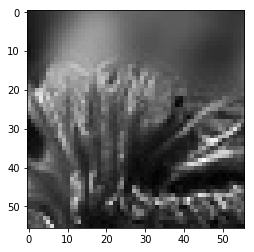

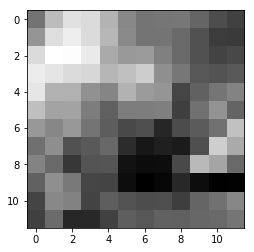

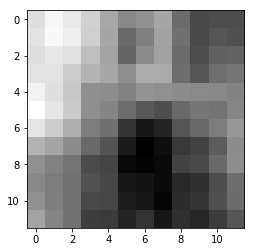

30.460045225918293

 next


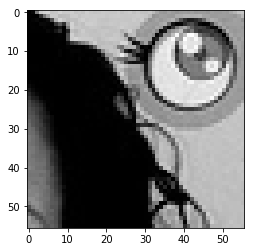

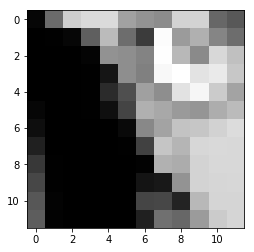

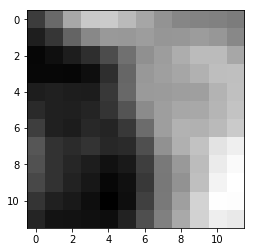

50.86171478033066

 next


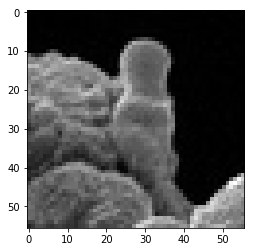

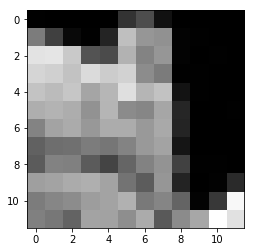

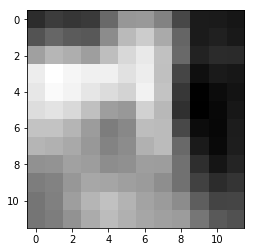

56.285646334290504

 next


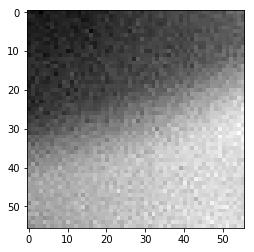

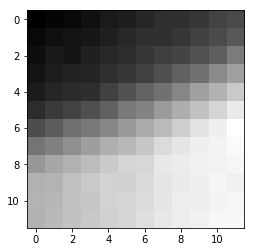

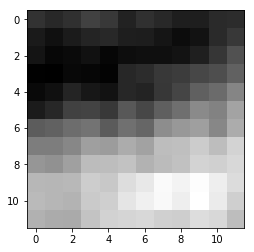

22.917888835072517

 next


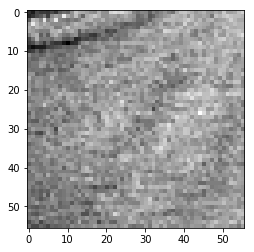

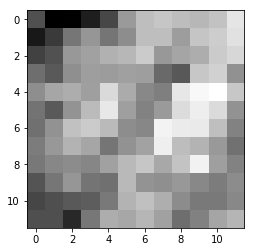

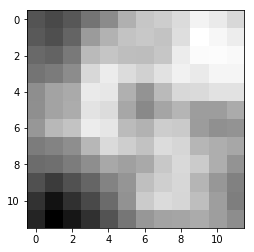

48.12880262732506

 next


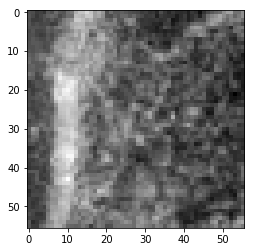

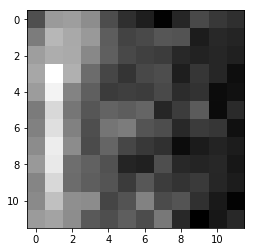

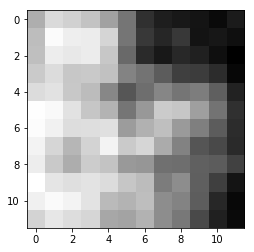

53.15207228064537

 next


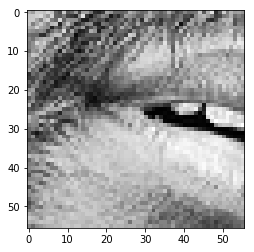

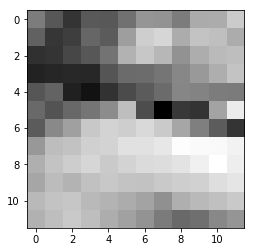

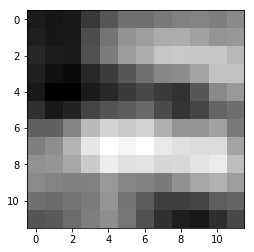

33.30932043492794

 next


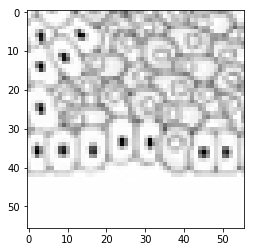

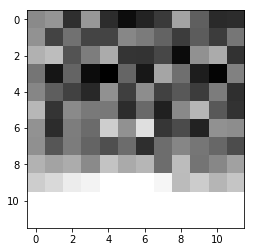

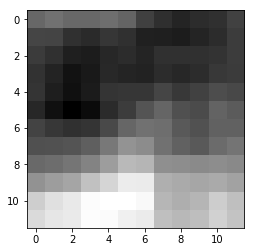

143.78053039312363

 next


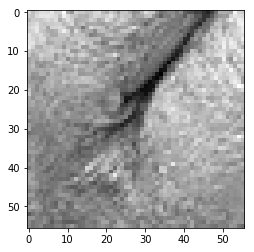

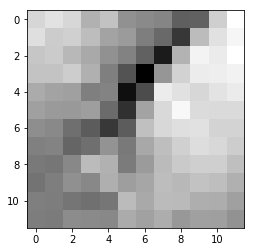

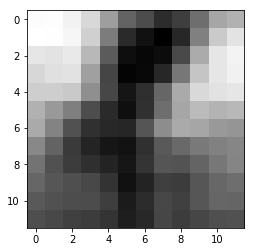

25.089631900191307

 next


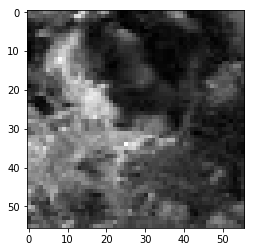

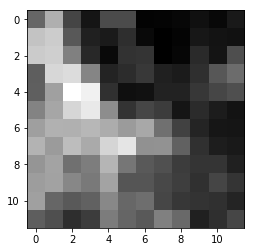

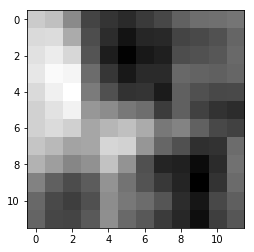

52.80820973217487

 next


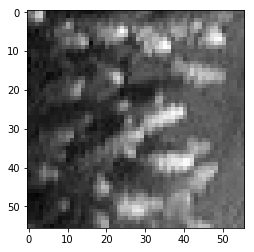

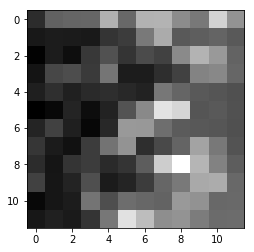

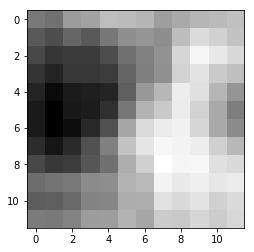

27.203312180936337

 next


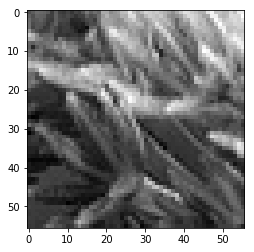

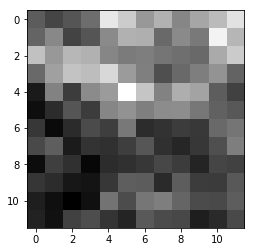

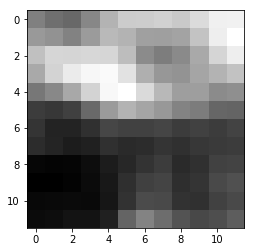

38.343225717544556

 next


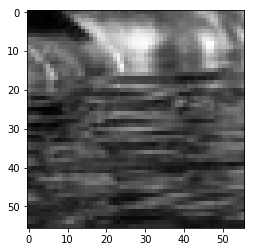

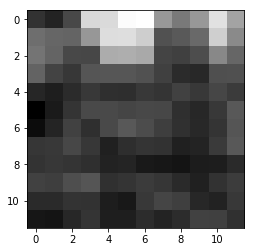

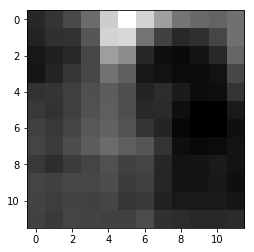

30.398444831371307

 next


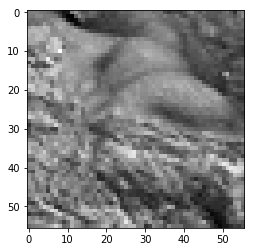

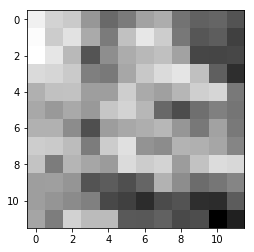

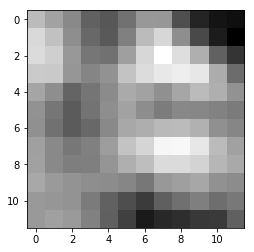

32.7737657725811

 next


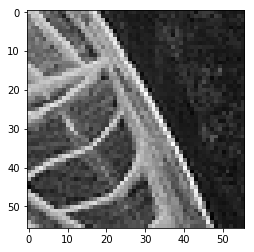

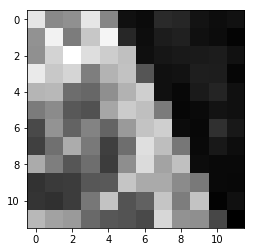

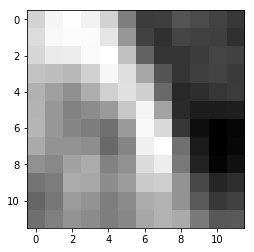

24.428575672209263

 next


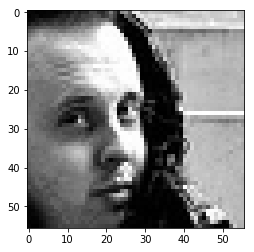

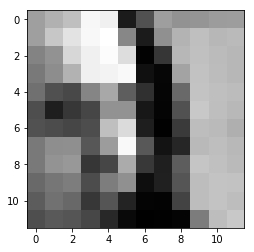

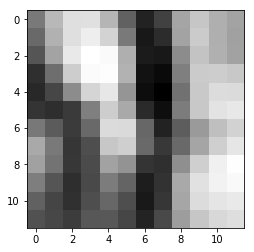

40.994647443294525

 next
0.16239214714616537


In [18]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (4, 4), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((12, 12))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [21]:
brief_ae = load_model('/scratch/image_datasets/2_for_learned_brief/ready/weights0.0.2.0.0_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12/weights.44-0.58.hdf5')